## CNN para previsão de fraturas

**Acerca do Dataset**
- Este conjunto de dados é composto por imagens de raios X fraturadas e não fraturadas de várias articulações. A tarefa é construir um classificador de imagens para detectar fraturas em determinada imagem de raio-X. Este conjunto de dados é composto por diferentes articulações nas extremidades superiores. O isolamento de articulações individuais é recomendado para melhorar o desempenho dos classificadores.
- 8863 instâncias para treino
- 600 instâncias para teste

### Imports

In [1]:
!pip install livelossplot

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

from livelossplot import PlotLosses

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

from torchvision.datasets import ImageFolder

from torchvision.models import alexnet

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import Resize

### 0. Preparar o Setup

In [3]:
PATH_TRAIN = '/kaggle/input/bone-fracture-detection-using-xrays/archive (6)/train'
PATH_TEST = '/kaggle/input/bone-fracture-detection-using-xrays/archive (6)/val'

BATCH_SIZE = 32

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


### 1. Preparar os dados

In [5]:
transform = Compose(
        [ToTensor(),
         Resize((224, 224),antialias=True),
         Normalize(mean=(0.1307,), std=(0.3081,))  # Normaliza as imagens
        ])

In [6]:
# Definir a seed

seed = 2024

torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Importar dataset
train_dataset = ImageFolder(PATH_TRAIN, transform=transform)
test_dataset = ImageFolder(PATH_TEST, transform=transform)

validation_split = 0.2
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

### 2. Definir o Modelo

In [7]:
M_alexnet = alexnet()

num_classes = len(train_dataset.classes)
M_alexnet.classifier[6] = torch.nn.Linear(4096, num_classes) # alteração na camada de saída

In [8]:
M_alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
# função de perda e otimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(M_alexnet.parameters(), lr=0.005, momentum=0.9)

### 3. Treinar o Modelo

In [10]:
EPOCHS = 15

def train_model(train_dl, val_dl, model, criterion, optimizer):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {}
        model.train()
        running_loss = 0.0
        running_corrects = 0.0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float()/len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
        model.eval()
        running_loss = 0.0
        running_corrects = 0.0
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()
        liveloss.update(logs)
        liveloss.send()


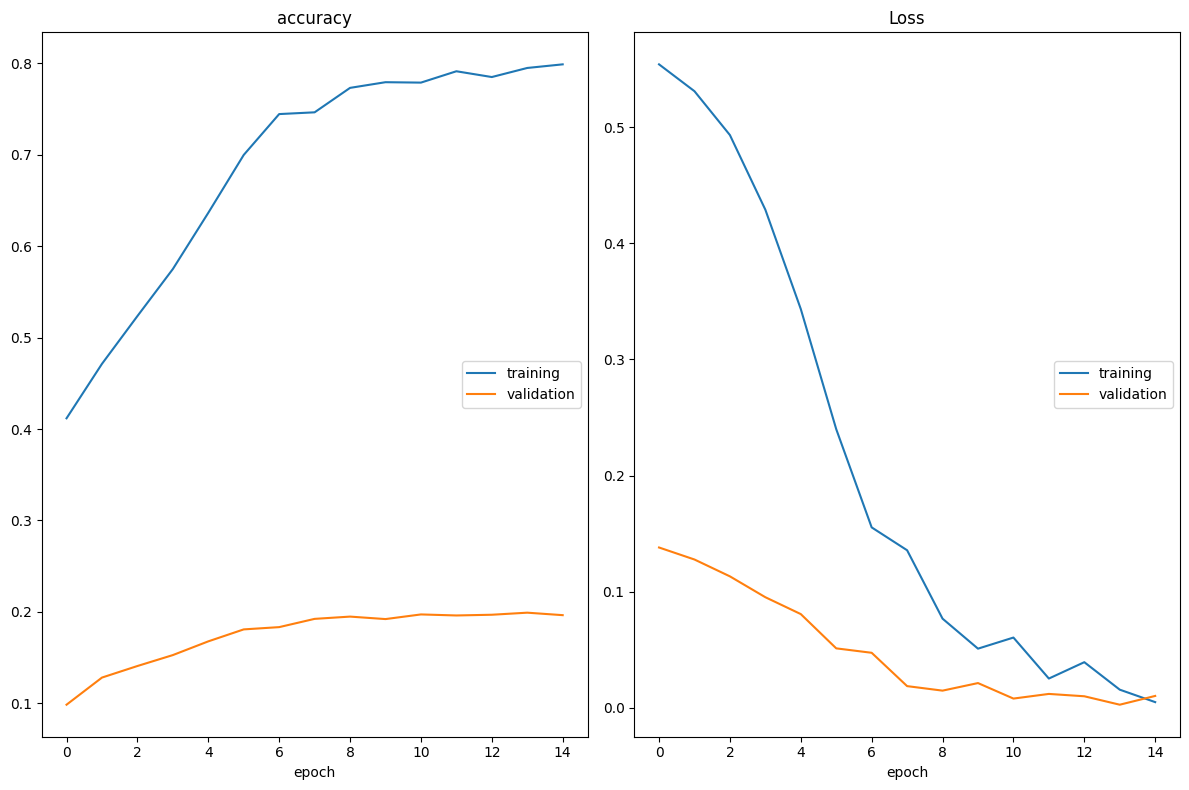

accuracy
	training         	 (min:    0.412, max:    0.799, cur:    0.799)
	validation       	 (min:    0.098, max:    0.199, cur:    0.196)
Loss
	training         	 (min:    0.005, max:    0.554, cur:    0.005)
	validation       	 (min:    0.003, max:    0.138, cur:    0.010)

Training completed in 463.75876688957214 seconds


In [11]:
start_time = time.time()

train_model(train_loader, val_loader, M_alexnet, criterion, optimizer)
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time} seconds")

### 4. Avaliar o modelo

In [18]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    device = next(model.parameters()).device
    
    model.eval()  # Garantir que o modelo está no modo de avaliação
    
    with torch.no_grad():  # Desativar o cálculo de gradientes durante a avaliação
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            yprev = model(inputs)
            yprev = yprev.detach().cpu().numpy()
            actual = labels.cpu().numpy()
            
            print(yprev);
                
            yprev = np.argmax(yprev, axis=1)
            
            actual = actual.reshape((len(actual), 1))
            yprev = yprev.reshape((len(yprev), 1))
            predictions.append(yprev)
            actual_values.append(actual)
            
    predictions = np.vstack(predictions)
    actual_values = np.vstack(actual_values)
    
    return actual_values, predictions

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (1285126648.py, line 16)

In [13]:
def display_predictions(actual_values, predictions):
    acertou = 0
    falhou = 0
    primeiros = 0
    for r, p in zip(actual_values, predictions):
        if primeiros < 20:
            print(f'real:{r} previsão:{p}')
            primeiros += 1
        if r == p:
            acertou += 1
        else:
            falhou += 1
    
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

In [14]:
def display_confusion_matrix(cm, list_classes):
    plt.figure(figsize=(16, 8))
    sns.heatmap(cm, annot=True, xticklabels=list_classes, yticklabels=list_classes, annot_kws={"size": 12},
                fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [17]:
actual_values, predictions = evaluate_model(test_loader, M_alexnet)
display_predictions(actual_values, predictions)

[[-5.160027   5.493744 ]
 [-6.0777736  6.4327564]
 [-3.8712366  4.0668125]
 ...
 [-4.31407    4.5171905]
 [-5.8925233  6.162733 ]
 [-6.1323156  6.409864 ]]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[0]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
Accuracy: 0.518

acertou:311 falhou:289


In [ ]:
print(classification_report(actual_values, predictions))

In [ ]:
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=['fratured', 'not fractured']
cm = confusion_matrix(actual_values, predictions)
print (cm)

In [ ]:
display_confusion_matrix(cm,list_classes)

### 5. Guardar o Modelo

In [ ]:
torch.save(M_alexnet, 'model_alexnet')